## MET CS677 Data Science with Python - Assignment 6
### Alan Szmyt
#### Built with Python 3.11.3

In [1]:
!python --version

Python 3.11.3


In [2]:
%%javascript
MathJax.Hub.Config({
    tex2jax: {
        inlineMath: [['$','$'], ['\\(','\\)']],
        processEscapes: true
    },
    tex: {
        packages: {'[+]': ['require']},
    },
});

<IPython.core.display.Javascript object>

In [3]:
import operator
import pandas as pd
import seaborn as sns
from pathlib import Path
from pandas import DataFrame
from IPython.display import Latex
from assignment6 import (
    log, create_latex_table, data_directory, LabelClasses, SeedsColumn,
    DATAFRAME_NAME, SEEDS_DATASET, SEEDS_SUBSET, LinearSVMModel,
    PolynomialSVMModel, GaussianSVMModel, KNNModel,
    AnalyticsCollection, ModelAnalyzer, ClassifierAnalytics,
    KMeansAnalyticsCollection, KMeansAnalytics, KMeansModel,
    WheatClass, KMEANS_CLASSIFIER_K,
)

# Global Seaborn options.
sns.set_theme(font_scale=1.5, rc={"text.usetex": True})
pd.set_option("display.precision", 2)
pd.set_option("styler.format.precision", 2)

# Choosing the 2 classes based upon BUID.
buid: str = "U38573068"
label_classes: LabelClasses = LabelClasses.select_classes(
    remainder=int(int(buid[-1]) % 3)
)

# seeds dataset file from UCI.
dataset_csv: str = "seeds_dataset.csv"
seeds_dataset_file: Path = data_directory.joinpath(dataset_csv)

In [4]:
# Load the whole dataset from the csv file.
seeds_dataset: DataFrame = pd.read_csv(
    filepath_or_buffer=seeds_dataset_file,
    delimiter="\t",
    engine="python",
    header=None,
    names=SeedsColumn.columns(),
    dtype=SeedsColumn.dtype()
)
seeds_dataset.attrs[DATAFRAME_NAME] = SEEDS_DATASET

In [5]:
# Create subset of dataset using the 2 selected classes.
seeds_subset: DataFrame = \
    seeds_dataset[seeds_dataset[SeedsColumn.CLASS].isin(label_classes.classes)]
seeds_subset.attrs[DATAFRAME_NAME] = SEEDS_SUBSET

# Machine learning model analyzer context class.
analyzer: ModelAnalyzer = ModelAnalyzer(
    dataset=seeds_subset, model=LinearSVMModel(predictor_col=SeedsColumn.CLASS)
)

In [6]:
seeds_subset_table: str = create_latex_table(
    seeds_subset.head(),
    label="tab:seeds_subset_datatable",
    caption="Seeds Subset"
)
Latex(seeds_subset_table)

<IPython.core.display.Latex object>

In [7]:
# Train linear svm model, make predictions, and gather analytics.
linear_svm_analytics: ClassifierAnalytics = analyzer.analyze()

In [8]:
    # Compute the accuracy.
log(
    f"Linear kernel SVM accuracy: "
    f"{linear_svm_analytics.confusion_matrix.accuracy.score}"
)

Linear kernel SVM accuracy: 92.86%


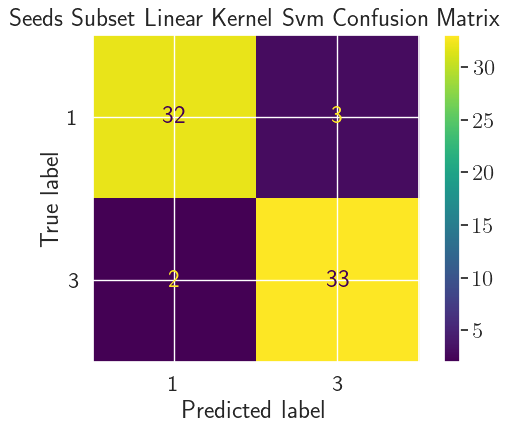

In [9]:
# Compute the confusion matrix.
linear_svm_analytics.show_confusion_matrix()

In [10]:
# Train gaussian svm model, make predictions, and gather analytics.
analyzer.model = GaussianSVMModel(predictor_col=SeedsColumn.CLASS)
gaussian_svm_analytics: ClassifierAnalytics = analyzer.analyze()

In [11]:
# Compute the accuracy.
log(
    f"Gaussian kernel SVM accuracy: "
    f"{gaussian_svm_analytics.confusion_matrix.accuracy.score}"
)

Gaussian kernel SVM accuracy: 95.71%


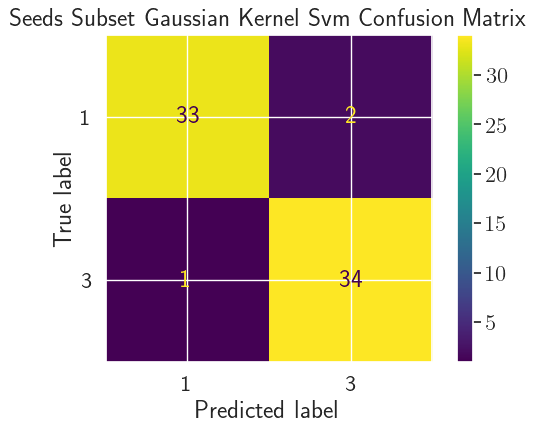

In [12]:
# Compute the confusion matrix.
gaussian_svm_analytics.show_confusion_matrix()

In [13]:
# Train polynomial svm model, make predictions, and gather analytics.
analyzer.model = PolynomialSVMModel(predictor_col=SeedsColumn.CLASS)
polynomial_svm_analytics: ClassifierAnalytics = analyzer.analyze()

In [14]:
# Compute the accuracy.
log(
    f"Polynomial kernel SVM accuracy: "
    f"{polynomial_svm_analytics.confusion_matrix.accuracy.score}"
)

Polynomial kernel SVM accuracy: 92.86%


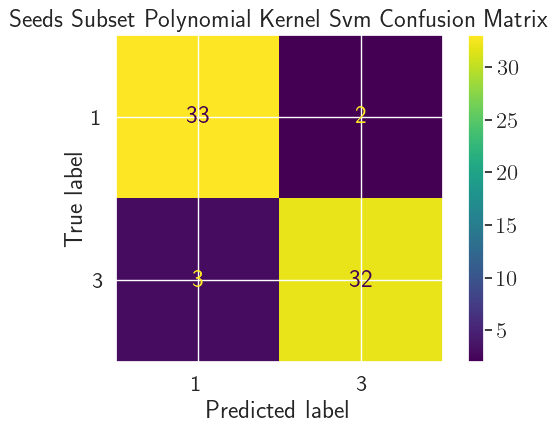

In [15]:
# Compute the confusion matrix.
polynomial_svm_analytics.show_confusion_matrix()

In [16]:
# Train kNN model, make predictions, and gather analytics.
analyzer.model = KNNModel(predictor_col=SeedsColumn.CLASS)
knn_analytics: ClassifierAnalytics = analyzer.analyze()

In [17]:
# Compute the accuracy.
log(
    f"kNN classifier accuracy: "
    f"{knn_analytics.confusion_matrix.accuracy.score}"
)

kNN classifier accuracy: 95.71%


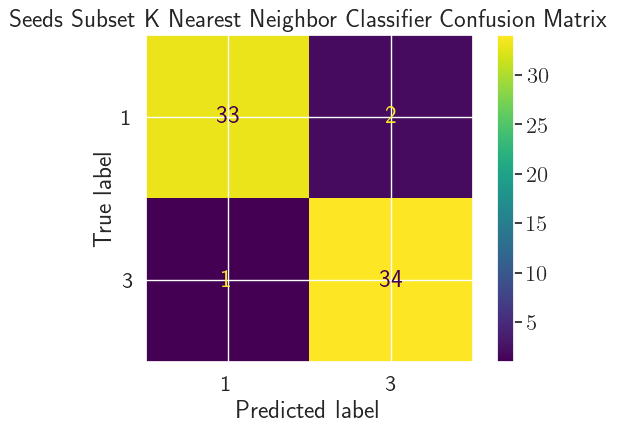

In [18]:
# Compute the confusion matrix.
knn_analytics.show_confusion_matrix()

In [19]:
# Gather analytics for all classifier models.
classifier_analytics: AnalyticsCollection = AnalyticsCollection(
    [
        linear_svm_analytics,
        gaussian_svm_analytics,
        polynomial_svm_analytics,
        knn_analytics,
    ]
)

In [20]:
# Generate the summary table from the analytics.
summary_table_df: DataFrame = classifier_analytics.summary_table
summary_table_df.attrs[DATAFRAME_NAME] = "classifier_summary_table"
summary_table: str = create_latex_table(
    summary_table_df.head(),
    label="tab:summary table",
    caption="Classifier Statistics Summary"
)
Latex(summary_table)

<IPython.core.display.Latex object>

In [21]:
# Train k-means clustering model, make predictions, and gather analytics.
analyzer.dataset = seeds_dataset
k_means_list: list[KMeansAnalytics] = []
for k in range(1, 8):
    analyzer.model = KMeansModel(
        predictor_col=SeedsColumn.CLASS,
        n_clusters=k,
        features=SeedsColumn.feature_columns(),
    )
    k_means_list.append(analyzer.analyze())

k_means_analytics: KMeansAnalyticsCollection = \
    KMeansAnalyticsCollection(k_means_list)

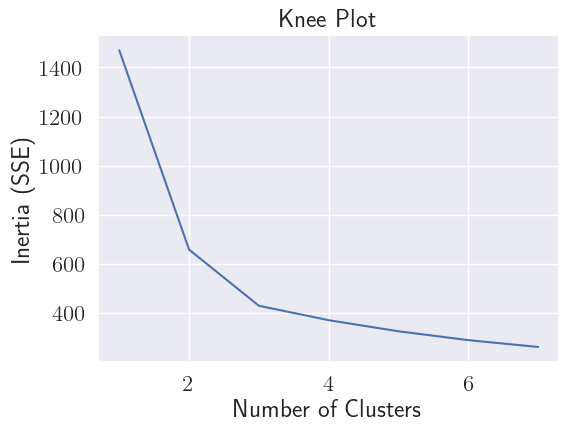

In [22]:
# Use the 'knee' method to find the best k.
optimal_k: int = k_means_analytics.show_knee_plot()

In [23]:
# The optimal k value found by the kneedle algorithm.
log(f"Optimal k value: {optimal_k}")

Optimal k value: 3


In [24]:
# Get two random feature columns, f_i and f_j.
random_features: list[str] = SeedsColumn.random_columns()[:2]

log(f"Random features: {', '.join(random_features)}")

Random features: asymmetry, width


In [25]:
# Use optimal k value for k-means clustering.
analyzer.model = KMeansModel(
    predictor_col=SeedsColumn.CLASS,
    n_clusters=optimal_k,
    features=random_features,
    label_transformer=WheatClass.from_label
    if optimal_k == KMEANS_CLASSIFIER_K else None,
)
optimal_k_means_analytics: KMeansAnalytics = analyzer.analyze()

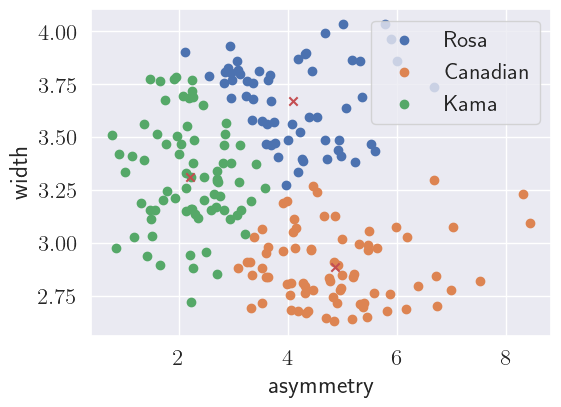

In [26]:
# Plot the random features.
optimal_k_means_analytics.plot(random_features, WheatClass.label_to_title)

In [27]:
# Use all features again.
analyzer.model = KMeansModel(
    predictor_col=SeedsColumn.CLASS,
    n_clusters=optimal_k,
    features=SeedsColumn.feature_columns(),
    label_transformer=WheatClass.from_label
)

# Print cluster centroid and assigned label.
for i, cluster in enumerate(optimal_k_means_analytics.clusters):
    log(
        f"Cluster {i+1}: "
        f"Centroid={cluster.centroid}, "
        f"Label={WheatClass.from_label(cluster.majority).to_title()}"
    )

Cluster 1: Centroid=[4.10076271 3.67005085], Label=Rosa
Cluster 2: Centroid=[4.87348684 2.88577632], Label=Canadian
Cluster 3: Centroid=[2.19616267 3.31273333], Label=Kama


In [28]:
if optimal_k < KMEANS_CLASSIFIER_K:
    # Rerun with k=3.
    analyzer.model = KMeansModel(
        predictor_col=SeedsColumn.CLASS,
        n_clusters=3,
        features=random_features,
        label_transformer=WheatClass.from_label,
    )
elif optimal_k > KMEANS_CLASSIFIER_K:
    # Find the largest 3 clusters.
    clusters = [
        cluster.dataset
        for cluster in sorted(
            optimal_k_means_analytics.clusters,
            key=operator.attrgetter("size"),
            reverse=True,
        )[:3]
    ]

    # Run k-means with largest 3 clusters.
    analyzer.dataset = pd.concat(clusters)

In [29]:
k_means_classifier_analytics: KMeansAnalytics = analyzer.analyze()

# Compute the accuracy.
log(
    f"K-means classifier accuracy: "
    f"{k_means_classifier_analytics.confusion_matrix.accuracy.score}"
)

K-means classifier accuracy: 97.22%


In [30]:
# Use the subset dataframe again.
analyzer.dataset = seeds_subset
k_means_classifier_subset_analytics: KMeansAnalytics = analyzer.analyze()

In [31]:
# Compute the accuracy.
log(
    f"K-means classifier on subset accuracy: "
    f"{k_means_classifier_subset_analytics.confusion_matrix.accuracy.score}"
)

K-means classifier on subset accuracy: 95.45%


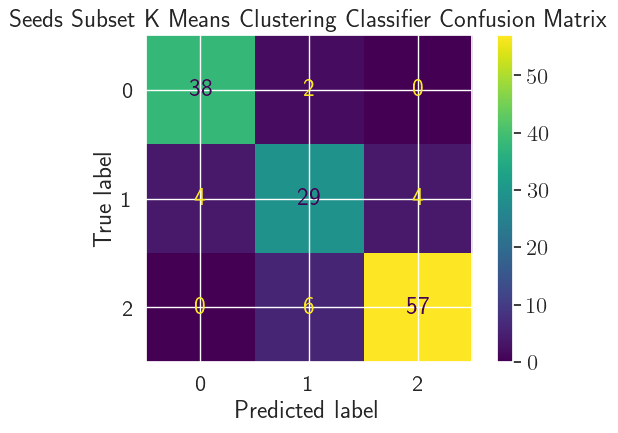

In [32]:
# Compute the confusion matrix.
k_means_classifier_subset_analytics.show_confusion_matrix()

In [33]:
# Generate the summary table from the analytics.
classifier_analytics.append(k_means_classifier_subset_analytics)
final_summary_df: DataFrame = classifier_analytics.summary_table
final_summary_df.attrs[DATAFRAME_NAME] = "final_classifier_summary_table"
final_summary_table: str = create_latex_table(
    final_summary_df.head(),
    label="tab:summary table",
    caption="Classifier Statistics Summary"
)
Latex(final_summary_table)

<IPython.core.display.Latex object>